
### __Note: This notebook has been built based on [ika-rwth-aachen/acdc-notebooks](https://github.com/ika-rwth-aachen/acdc-notebooks). Fell free to check the original repository and give them a star if you like ;)__

# Introduction

The goal of this notebook is to train an U-net model with semantically segmented images. Just run every cell and change the parameters in the __Parameters__ section in case necessary. Have fun!!

Let's start by importing all the necessary imports:

In [111]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import random
import glob
import cv2
import time
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate

from segmentation_utils.metrics import SparseMeanIoU

random.seed(123)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

# Dataset

For this assignment we will use our own annotated images. Please change the paths for `images_path_train` and `labels_path_train` accordingly. Now, we will start inspecting the dataset:

In the following cell, the file paths for each image and label are extracted and lists. Then the datasets are shuffled.

In [38]:

images_path_train = "datasets/Test_with_aug/images"
labels_path_train = "datasets/Test_with_aug/semantic_rgb"


# get file pathes
images_path_train = sorted(glob.glob(os.path.join(images_path_train, "*.png")))
labels_path_train = sorted(glob.glob(os.path.join(labels_path_train, "*.png")))

# shuffle the dataset
fused_list = list(zip(images_path_train, labels_path_train))
random.shuffle(fused_list)
images_path_train, labels_path_train = map(list, zip(*fused_list))

print(images_path_train[0])
print(labels_path_train[0])

datasets/Test_with_aug/images/125_random_brightness_3.png
datasets/Test_with_aug/semantic_rgb/125_random_brightness_3.png


We can visualize image and label with the library `matplotlib`:

In [39]:
plt.imshow(plt.imread(images_path_train[0]))
plt.show()

plt.imshow(plt.imread(labels_path_train[0]))
plt.show()

## Color Class Association

For a better visualisation the classes of the segmented image are colorized. That means, each class is associated with a certain color. The association between the color and the classes is stored in the following dictionary. It contains the mapping from __RGB color code__ to the __class ID__. As you can see, each class corresponts also to a semantic class such as __right_line__, __left_line__ or __parking_area__.

In [40]:
rgb_to_class_id = {
    (61, 61, 245):  0,   # right_line
    (115, 51, 128):  1,   # left_line
    (245, 147, 49):  2,   # dashed_center_line
    (36, 179, 83):  3,   # right_lane
    (250, 50, 83):  4,   # left_lane
    (51, 221, 255):  5,   # start_line
    (250, 50, 183): 6,   # parallel_parking_area
    (250, 125, 187): 7,   # perpendicular_parking_area
    (250,  250,  55): 8,   # intersection_area
    (89, 134, 179):  9,   # start_box
    (178, 80, 80):  10,   # stop_line
    (0,  0,  0): 11   # background

}

# Convertion of RGB label image into a segmentation map

To convert the label RBG image into a representation that can be processed by the neural network, it is necessary to convert the __RBG encoding__ into a __segmentation map__.
- The __segmentation map__ represents each label class with an integer from $0 ... 3$. The representation has size $4x4x1$


In [41]:
def convert_rgb_encoding_to_segmentation_map(image, rgb_to_class_id):
    """
    Converts an image with the RGB class encoding into a class map.
    
    Argument:
    image -- tf.tensor of shape [heigh, width, 3] which contains for each pixel a tuple of (R, G, B) values.
    
    Returns:
    class_map -- tf.tensor of shape [heigh, width, 1] which contains for each pixel a single integer that represents a class
    """

    segmentation_map = tf.zeros([image.shape[0], image.shape[1]], dtype=tf.uint8)

    for color, class_id in rgb_to_class_id.items():    
    ### START CODE HERE ###
    
        segmentation_map = tf.where(
                                    condition=tf.reduce_all(tf.equal(image, color), axis=-1), # condition=None,
                                    x=tf.cast(class_id, tf.uint8),                            # x=None,
                                    y=segmentation_map                                        # y=None
                                    )
        
    # Add dimension to change the shape from [height, width] to [height, width, 1]
    segmentation_map = tf.expand_dims(segmentation_map, -1)  # segmentation_map = None
    ### END CODE HERE ###
        
    return segmentation_map

## Build TensorFlow input pipeline
In the following we will build up an efficient Tensorflow pipeline for the image segmentation dataset. We will use the [tf.data](https://www.tensorflow.org/guide/data) API for seamless interaction with the Tensorflow model that we will construct later.

# Parse sample from the dataset

As you have seen above, the dataset consists of several samples. Each sample consist of an image-label pair. The function `parse_sample` processes such a sample from the dataset. It receices the path for the image and label and then decodes the `png` files. We then resize all samples to the same size, because some samples in the dataset have different sizes. Then we will apply the function `convert_rgb_encoding_to_segmentation_map` that we have implemented above.


In [48]:
def parse_sample(image_path, label_path):
    """
    Argument:
    image_path -- String which contains the path to the camera image
    label_path -- String which contains the path to the label image
    
    Returns:
    image_rgb -- tf.Tensor of size [368, 1248, 3] containing the camera image
    label_segmentation_map -- tf.Tensor of size [368, 1248, 1] containing the segmentation map
    """
    ### START CODE HERE ### 
    image_rgb = tf.image.decode_png(tf.io.read_file(image_path), channels=3)  # image_rgb = None
    label_rgb = tf.image.decode_png(tf.io.read_file(label_path), channels=3)  # label_rgb = None
    
    
    # Resize all images and labels to a uniform size, because some images in the dataset have different sizes
    image_rgb = tf.image.resize(image_rgb, [320, 320], method=tf.image.ResizeMethod.BILINEAR)  # do not modify
    label_rgb = tf.image.resize(label_rgb, [320, 320], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # do not modifly
    
    # resize returns tf.float32 for BILINEAR, convert back to tf.uint8
    image_rgb = tf.cast(image_rgb, tf.uint8) 
    
    # apply convert_rgb_encoding_to_segmentation_map to the label_rgb image
    label_segmentation_map = convert_rgb_encoding_to_segmentation_map(label_rgb, rgb_to_class_id)  # label_segmentation_map = None
    ### END CODE HERE ###
    
    return image_rgb, label_segmentation_map

## Data Normalization


Data normlization the to process to normalize the input data from an abitrary range to range $[-1, 1]$ or $[0,1 ]$. In doing so the machine learning approach often converges faster than using not normalized data.


In [49]:
def normalize(image, label):
    """
    Normalizes the input image from range [0, 255] to [0, 1.0]
    Arguments:
    image -- tf.tensor representing a RGB image with integer values in range [0, 255] 
    label -- tf.tensor representing the corresponding segmentation mask
    
    Returns:
    image -- tf.tensor representing a RGB image with integer values in range [0, 1] 
    label -- tf.tensor representing the corresponding segmentation mask
    """
    image = tf.cast(image, tf.float32) / 255.0  # image = None
    
    return image, label

# Dataset creation 
The [tf.data API](https://www.tensorflow.org/guide/data) allows to build efficient data pipelines for our training. It uses the class [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) class. Such a dataset object can then be later used for training the model. The dataset pipeline runs through the following steps:



In [81]:
def create_dataset(images_path, labels_path, batch_size, buffer_size=200):
    """
    Arguments:
    images_path -- List of Strings which contain pathes for the camera images
    labels_pathh -- List of Strings which contain pathes for the label images
    
    Returns:
    dataset -- tf.data.Dataset
    """
    
    ### START CODE HERE ### 
    # Create tf.data.Dataset from images_path and labels_path, replace both None placeholders
    dataset = tf.data.Dataset.from_tensor_slices((images_path, labels_path))  # dataset = tf.data.Dataset.from_tensor_slices((None, None))
    # Shuffle the dataset with buffer_size
    dataset = dataset.shuffle(buffer_size=buffer_size)                        # dataset = None
    # Apply the parse_sample function. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = dataset.map(parse_sample, num_parallel_calls=tf.data.AUTOTUNE)  # dataset = None
    # Apply data normalization. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)     # dataset = None
    # Apply batching to the dataset using batch_size
    dataset = dataset.batch(batch_size=batch_size)                            # dataset = None
    # Use prefetching 
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)                  # dataset = None
    ### END CODE HERE ###
    return dataset

# Create Train Val Split

For our training, we would like to split the dataset into a __train__ set and __val__ set. 

__Note: change the `split_ratio` and `batch_size` here__

In [87]:
split_ratio = 0.95

batch_size = 16


Now, we know the `train_size` and we can apply it to class functions `take` and `skip` to split the dataset into `train` and `val` dataset

In [88]:
# get number of data samples
length = len(images_path_train)

#set the train_size
train_size = round(length*split_ratio) 


train = create_dataset(images_path_train[:train_size], labels_path_train[:train_size], batch_size)
val = create_dataset(images_path_train[train_size:], labels_path_train[train_size:], batch_size)



print("Train Dataset Length:", tf.data.experimental.cardinality(train).numpy())
print("Val Dataset Length:", tf.data.experimental.cardinality(val).numpy())

Train Dataset Length: 26
Val Dataset Length: 2


# Model Architecture

In this assignment we will use the U-Net architecture for the task of semantic image segmentation. It was originally developed for medical image analysis, but we will use this easy-to-train architecture here in our assignment. We do not require you to construct or programm any lowlevel parts of this architecture, but you are free to read the following code and try to understand how this model is constructed. We will later use the functions `encoder()` and `decoder()` to assemble the network. In case you are interested about the particular architecture, feel free to read the corresponding [paper](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

In [55]:
def encoder(input,
            udepth,
            filters1,
            kernel_size,
            activation,
            batch_norm,
            dropout):

    t = input
    encoder_layers = udepth * [None]

    # layer creation with successive pooling
    for d in range(udepth):
        filters = (2**d) * filters1
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = encoder_layers[d] = BatchNormalization()(t) if batch_norm else t
        if d < (udepth - 1):
            t = MaxPooling2D(pool_size=(2, 2), padding="same")(t)
            t = Dropout(rate=dropout)(t) if dropout > 0 else t

    return encoder_layers


def decoder(encoder_layers,
            udepth,
            filters1,
            kernel_size,
            activation,
            batch_norm,
            dropout):

    # start at lowest encoder layer
    t = encoder_layers[udepth - 1]

    # layer expansion symmetric to encoder
    for d in reversed(range(udepth - 1)):
        filters = (2**d) * filters1
        t = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=(2, 2),
                            padding="same")(t)

        t = Concatenate()([encoder_layers[d], t])
        t = Dropout(rate=dropout)(t) if dropout > 0 else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t

    return t

# Assembling of the U-Net segmentation model

To construct the whole model, we will use the encoder part and decoder part of the network and connect them with each other. We will also have to define an input layer and some output operations.

In [89]:
def getModel(input_shape,
             num_classes,
             udepth=5,
             filters1=16,
             kernel_size=(3, 3),
             activation=tf.nn.relu,
             batch_norm=True,
             dropout=0.1):
    """
    This function assembles the U-Net architecture and returns a Keras model which can be trained, saved and loaded.
    
    Arguments:
    input_shape -- Input shape of the model as tuple or list
    num_classes -- Number of classes to predict as int
    udepth -- Depth of the network
    filters1 -- Number of filters at the first layer
    kernel_size -- Kernel size for the convolutional operations
    activation -- Type of the Activation function
    batch_norm -- Boolean if batch norm should be applied
    dropout -- Dropout regularization  
    
    Returns:
    segmentation_model -- Keras Model
    """
    
    ### START CODE HERE ### 
    
    # create input layer
    input_tensor = Input(input_shape)  # input_tensor = None

    # construct encoder
    encoder_layers = encoder(input=input_tensor,     # input=None,
                             udepth=udepth,          # udepth=None,
                             filters1=filters1,      # filters1=None,
                             kernel_size=kernel_size,# kernel_size=None,
                             activation=activation,  # activation=None,
                             batch_norm=batch_norm,  # batch_norm=None,
                             dropout=dropout         # dropout=None
                            )

    # construct decoder
    reconstruction = decoder(encoder_layers=encoder_layers, # encoder_layers=None,
                             udepth=udepth,                 # udepth=None,
                             filters1=filters1,             # filters1=None,
                             kernel_size=kernel_size,       # kernel_size=None,
                             activation=activation,         # activation=None,
                             batch_norm=batch_norm,         # batch_norm=None,
                             dropout=dropout                # dropout=None
                            )

    # build final prediction layer
    logits = Conv2D(filters=num_classes,                    # filters=None
                    kernel_size=kernel_size,
                    padding="same",
                    activation=activation)(reconstruction)  # activation=activation)(None)
    
    # apply softmax activation function to the logits 
    probabilities = Activation("softmax")(logits)           # probabilities = None
    
    # create a Keras model
    segmentation_model = Model(inputs=input_tensor, outputs=probabilities)   # segmentation_model = Model(inputs=None, outputs=None)
    
    ### END CODE HERE ###
    
    return segmentation_model

### Test: `getModel`

In [90]:
model = getModel(input_shape=[320, 320, 3], num_classes=12)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 320, 320, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 320, 320, 16  64         ['conv2d_38[0][0]']              
 ormalization)                  )                                                           

# Model training

Once our model is setup up correctly we can compile it by adding an __optimizer__ to the model, a __loss function__ and we can also add more __metrics__ in order to observe the training progress.

In [92]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=[SparseMeanIoU(num_classes=12, name="MIoU")])

Now, the training of the model can be evoked by calling the class function `fit`.


In [93]:
history = model.fit(train, validation_data=val, epochs=15)

Epoch 1/15
26/26 [==============================] - 12s 249ms/step - loss: 1.7997 - MIoU: 0.0640 - val_loss: 1.3692 - val_MIoU: 0.0631
Epoch 2/15
26/26 [==============================] - 6s 235ms/step - loss: 0.8872 - MIoU: 0.1176 - val_loss: 1.2909 - val_MIoU: 0.0615
Epoch 3/15
26/26 [==============================] - 6s 235ms/step - loss: 0.6092 - MIoU: 0.1567 - val_loss: 2.0534 - val_MIoU: 0.0631
Epoch 4/15
26/26 [==============================] - 6s 237ms/step - loss: 0.4823 - MIoU: 0.2109 - val_loss: 1.8579 - val_MIoU: 0.0631
Epoch 5/15
26/26 [==============================] - 6s 237ms/step - loss: 0.3825 - MIoU: 0.2511 - val_loss: 2.1113 - val_MIoU: 0.0631
Epoch 6/15
26/26 [==============================] - 6s 238ms/step - loss: 0.3276 - MIoU: 0.2720 - val_loss: 2.0401 - val_MIoU: 0.0669
Epoch 7/15
26/26 [==============================] - 6s 237ms/step - loss: 0.2874 - MIoU: 0.2882 - val_loss: 1.8536 - val_MIoU: 0.0653
Epoch 8/15
26/26 [==============================] - 6s 237ms/

# Save the Model

set the path where you want to save the model. Be careful not to overwrite any of the existing models.

In [60]:
model.save('saved_model/best_test_with_aug')

INFO:tensorflow:Assets written to: saved_model/best_test_with_aug/assets


INFO:tensorflow:Assets written to: saved_model/best_test_with_aug/assets


# Model Loading

The pretrained model can be loaded into the existing model by using the function `load_weights`. In case needed to load a previous trained model, uncomment the following cell and set the path of your pretrained model.

In [109]:
#model.load_weights("saved_model/best_test_with_aug/")

# Apply Class-Color Association 
You may remeber that at the beginning we transformed the __RGB encoding__ into a __segmentation map__. Now we want to perform the same operation in reverse ! We want to convert the __segmentation map__ into the __RGB encoding__ for a nicer visualization.


In [104]:
def segmentation_map_to_rgb_encoding(segmentation_map, rgb_to_class_id):
    """
    Converts the segmentation map into a RGB encoding
    
    Arguments:
    segmentation_map -- Numpy ndArray of shape [height, width, 1]
    rgb_to_class_id -- Dictionary which contains the association between color and class ID
    
    Returns:
    rgb_encoding -- Numpy ndArray of shape [height, width, 3]
    """

    rgb_encoding = np.zeros([segmentation_map.shape[0], segmentation_map.shape[1], 3], dtype=np.uint8)
    
    for color, class_id in rgb_to_class_id.items():       # for color, class_id in None:
        
        rgb_encoding[segmentation_map==class_id] = color  # rgb_encoding[None==None] = None
    
    return rgb_encoding

# Model Inference

Now let's see the predictions on the validation set

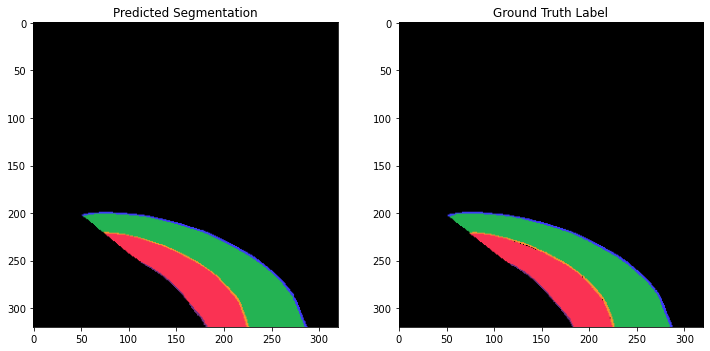

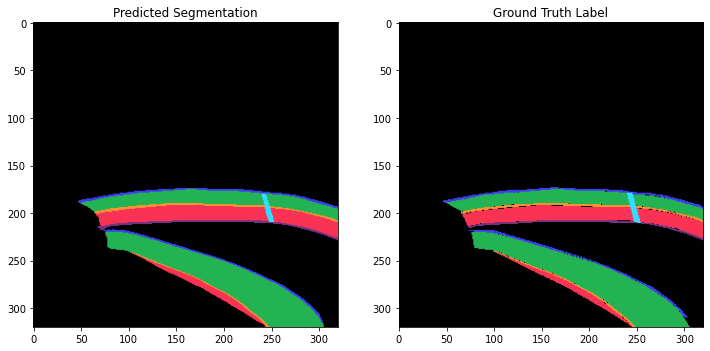

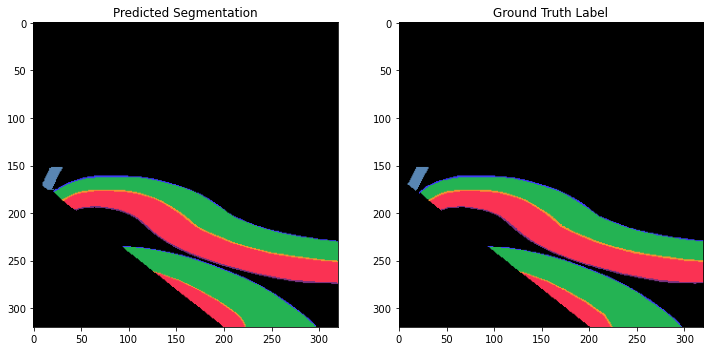

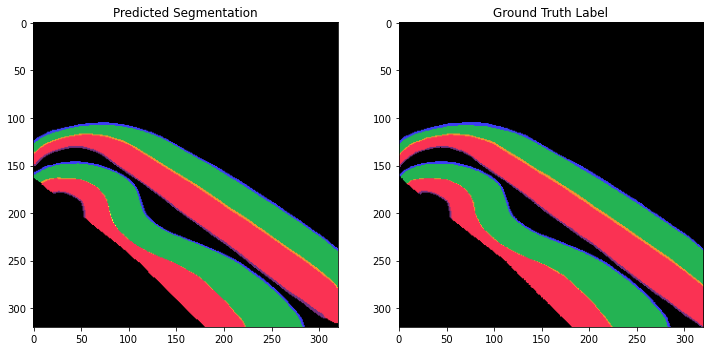

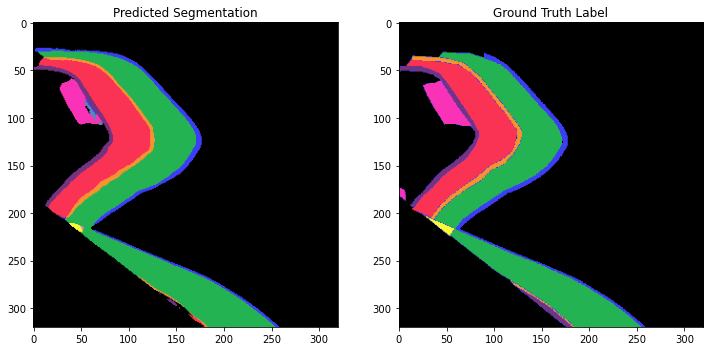

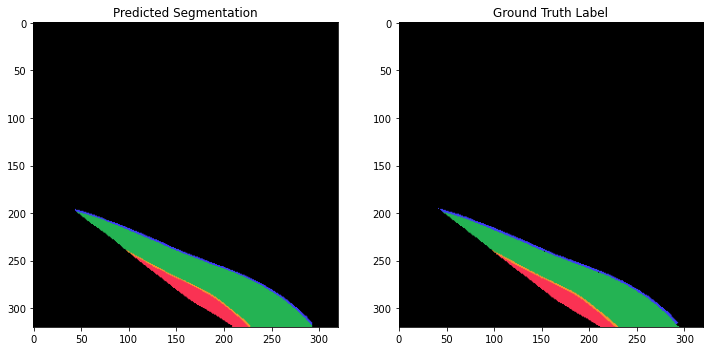

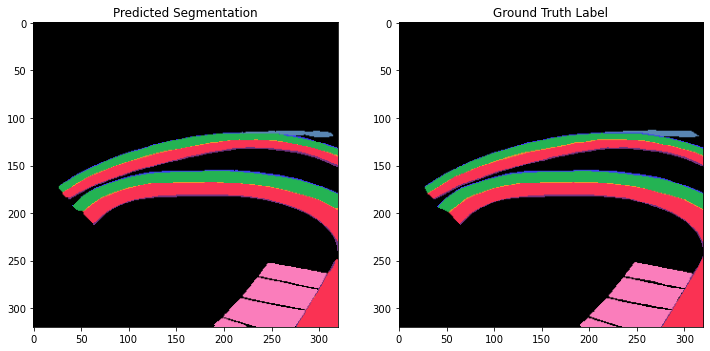

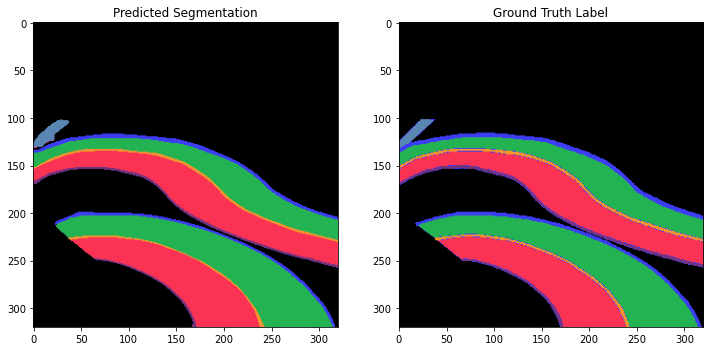

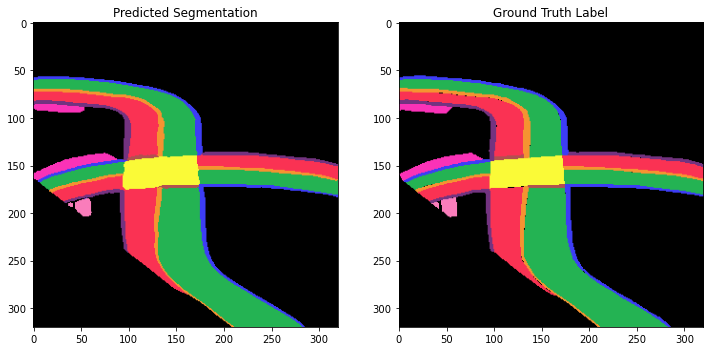

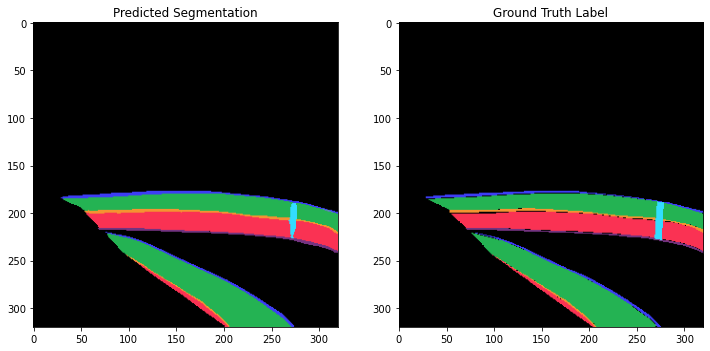

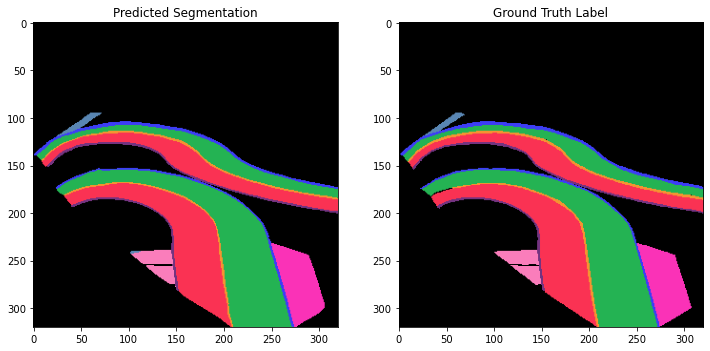

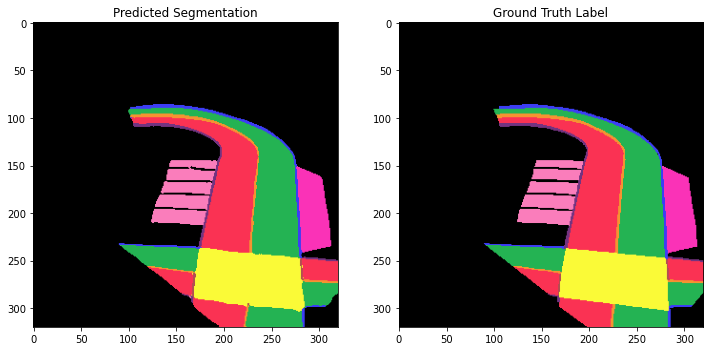

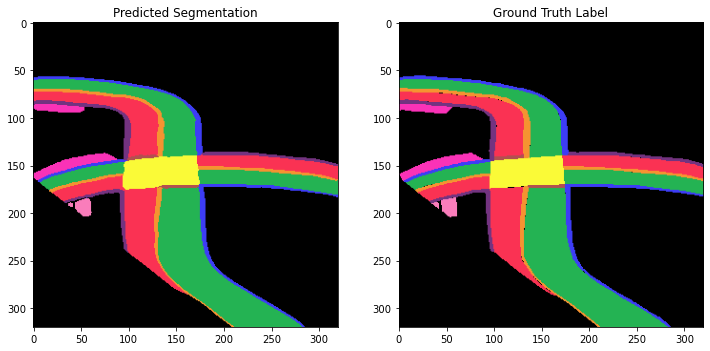

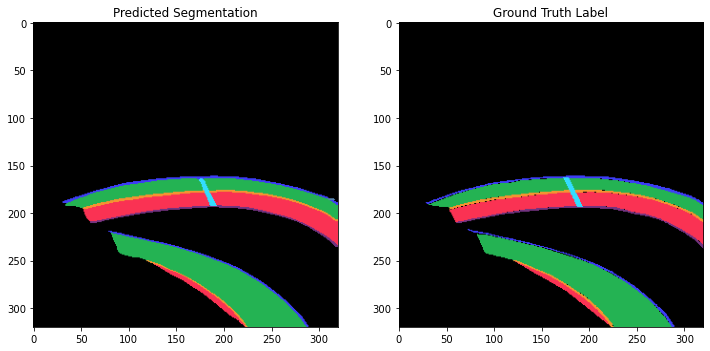

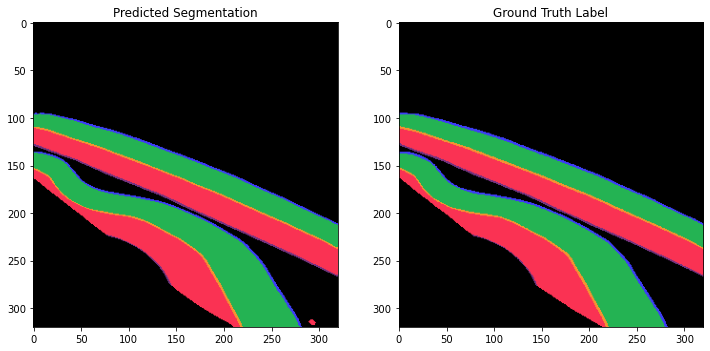

In [115]:

# Loop through the validation dataset and display predictions and labels
for i in range(length-train_size):
    
    image, label = parse_sample(images_path_train[-(i+1)], labels_path_train[-(i+1)])
    image, label = normalize(image, label)

    # add batch dimension
    image = tf.expand_dims(image, axis=0)

    # Perform inference on the current image
    probabilities = model.predict(image,verbose= 0)
    prediction = tf.argmax(probabilities, axis=-1)
    prediction = tf.squeeze(prediction)

    # Convert segmentation maps to RGB encoding for visualization
    
    rgb_predicted = segmentation_map_to_rgb_encoding(prediction, rgb_to_class_id)
    rgb_label = segmentation_map_to_rgb_encoding(np.squeeze(label), rgb_to_class_id)


    # Display the predictions and labels
    plt.figure(figsize=(12, 12))

    plt.subplot(1, 2, 1)
    plt.imshow(rgb_predicted)
    plt.title("Predicted Segmentation")

    plt.subplot(1, 2, 2)
    plt.imshow(rgb_label)
    plt.title("Ground Truth Label")

    plt.show()


# Infenrence on Video

you can test your model on a video with the following cell.

In [117]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import time
from tqdm import tqdm

# Input video path and output video path
input_video_path = 'video_conversion/video/output-video_SOJhUzMZ.mp4' 
output_video_path = 'test.mp4' 

# Open the input video file
video_capture = cv2.VideoCapture(input_video_path)

# Get video properties (frame width, height, and frame rate)
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_capture.get(cv2.CAP_PROP_FPS))

# Create VideoWriter object to save the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Specify the codec (may need to change based on your system)
output_video = cv2.VideoWriter(output_video_path, fourcc, fps, (320, 320))

frame_count = 0
start_time = time.time()

# Calculate total number of frames for tqdm
total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

# Use tqdm to display progress
for _ in tqdm(range(total_frames)):
    ret, frame = video_capture.read()  # Read a frame from the video

    if not ret:
        break  # Break the loop if no frame is read

    frame = cv2.resize(frame, (320, 320))

    # Preprocess the frame if needed (resize, normalize, etc.)
    processed_frame = frame  # Placeholder for preprocessing
    
    processed_frame = tf.cast(processed_frame, tf.uint8) 
    # Add batch dimension and normalize
    input_frame = tf.cast(processed_frame, tf.float32) / 255.0
    input_frame = tf.expand_dims(input_frame, axis=0)
    
    # Perform inference on the processed frame
    probabilities = model.predict(input_frame,verbose= 0)
    
    # Compute the segmentation map
    prediction = tf.argmax(probabilities, axis=-1)
    prediction = tf.squeeze(prediction)  
    
    rgb_encoding = segmentation_map_to_rgb_encoding(prediction, rgb_to_class_id)
    
    # Convert BGR to RGB
    rgb_encoding = cv2.cvtColor(rgb_encoding, cv2.COLOR_BGR2RGB)
    
    # Calculate FPS
    frame_count += 1
    elapsed_time = time.time() - start_time
    fps_calc = frame_count / elapsed_time

    # Add FPS text to the frame
    fps_text = f"FPS: {fps_calc:.2f}"
    cv2.putText(rgb_encoding, fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Write the output frame to the output video file
    output_video.write(rgb_encoding)

# Release video capture and writer objects
video_capture.release()
output_video.release()
cv2.destroyAllWindows()


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1267/1267 [01:06<00:00, 18.97it/s]
